In [0]:
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib
#matplotlib.use('TkAgg')
from mpl_toolkits.mplot3d import Axes3D
import time
import math

In [0]:
def D2R(R):
  return (R/180)*math.pi

In [0]:
class arm:
  
  def __init__(self):
    #                      alpha      a (mm)      d       theta
    DH =  np.array([[        0.,      0.,       360.,         0.],
                    [-math.pi/2,      0.,         0.,         0.],
                    [        0.,    330.,         0.,         0.],
                    [-math.pi/2,      0.,       300.,         0.],
                    [ math.pi/2,      0.,         0.,         0.],
                    [-math.pi/2,      0.,         0.,         0.]])
    
    #target set                     1        2        3        4       5
    self.target = np.array([[    100.,    200.,   -300.,    150.,    210.],  #X
                            [    100.,   -400.,   -100.,    100.,    200.],  #Y
                            [    100.,    100.,   -100.,    100.,    100.],  #Z
                            [ D2R(90), D2R(90), D2R(90), D2R(90), D2R(90)],  #Roll
                            [ D2R( 0), D2R( 0), D2R( 0), D2R( 0), D2R( 0)],  #Pitch
                            [ D2R( 0), D2R( 0), D2R( 0), D2R( 0), D2R( 0)],  #Yall
                            [       1,       1,       1,       1,       1]]) #Time
    
    
    self.GrapperOffset = 80. #along +Z axis
    
    self.alpha0 = DH[0,0]
    self.alpha1 = DH[1,0]
    self.alpha2 = DH[2,0]
    self.alpha3 = DH[3,0]
    self.alpha4 = DH[4,0]
    self.alpha5 = DH[5,0]


    self.a0 = DH[0,1]
    self.a1 = DH[1,1]
    self.a2 = DH[2,1]
    self.a3 = DH[3,1]
    self.a4 = DH[4,1]
    self.a5 = DH[5,1]

    self.d1 = DH[0,2]
    self.d2 = DH[1,2]
    self.d3 = DH[2,2]
    self.d4 = DH[3,2]
    self.d5 = DH[4,2]
    self.d6 = DH[5,2]

    self.theta1 = 0
    self.theta2 = 0
    self.theta3 = 0
    self.theta4 = 0
    self.theta5 = 0
    self.theta6 = 0
    
    #init point for plot
    self.joint0 = np.array([0,0,0,1])
    self.joint1 = np.array([0,0,0,1])
    self.joint2 = np.array([0,0,0,1])
    self.joint3 = np.array([0,0,0,1])
    self.joint4 = np.array([0,0,self.GrapperOffset,1])

    self.wx = 0
    self.wy = 0
    self.wz = 0
    self.px = 0
    self.py = 0
    self.pz = 0
    self.roll = 0
    self.pitch = 0
    self.yaw = 0
    self.runTime = 0

    self.goalF = 0


    self.fix = np.array([[-600 , -600 , 600 , 600 , -600 , -600 , 600 ,  600 ],
                         [ 600 , -600 ,-600 , 600 ,  600 , -600 ,-600 ,  600 ],
                         [   0 ,    0 ,   0 ,   0 ,  600 ,  600 , 600 ,  600 ]])

  def setGoal_W(self,Px,Py,Pz,Roll,Pitch,Yaw,RunTime):
    self.px = Px
    self.py = Py
    self.pz = Pz
    self.yaw = Yaw 
    self.roll = Roll
    self.pitch = Pitch
    self.runTime = RunTime

    r_z = np.array([[ math.cos(self.yaw), -math.sin(self.yaw), 0],
                    [ math.sin(self.yaw),  math.cos(self.yaw), 0],
                    [                  0,                   0, 1]])

    r_y = np.array([[  math.cos(self.pitch), 0, math.sin(self.pitch)],
                    [                     0, 1,                    0],
                    [ -math.sin(self.pitch), 0, math.cos(self.pitch)]])

    r_x = np.array([[ 1,                   0,                    0],
                    [ 0, math.cos(self.roll), -math.sin(self.roll)],
                    [ 0, math.sin(self.roll),  math.cos(self.roll)]])


    off_6 = np.array([0,0,self.GrapperOffset])
    self.Rrpy = np.dot( np.dot(r_x,r_y),r_z)
    #print(np.dot(self.Rrpy , off.T))
    W = np.dot(self.Rrpy, off_6.T*(1))

    #print(W)
    self.wx = self.px - W[0]
    self.wy = self.py - W[1]
    self.wz = self.pz - W[2]
    self.goalF = 1
    #self.wz = 35

  def FindTheta1_3(self):
    self.theta1 = math.atan(self.wy/self.wx)
    Wc0 = math.sqrt((self.wx)**2 + (self.wy)**2 + (self.wz)**2)
    Wc1 = math.sqrt((self.wx)**2 + (self.wy)**2 + (self.wz-self.d1)**2)
    #print("r= %f" %float(math.sqrt((self.wx)**2 + (self.wy)**2)))
    #print("Wc0= %f" %float(Wc0))
    #print("Wc1= %f" %float(Wc1))
    #print((self.d1**2 + Wc1**2 - Wc0**2 )/(2*self.d1*Wc1))
    phy1 = math.acos((self.d1**2 + Wc1**2 - Wc0**2 )/(2*self.d1*Wc1))
    phy2 = math.acos((Wc1**2 + self.a2**2 - self.d4**2)/(2*Wc1*self.a2))

    #print("phy1 = %f" %phy1)
    #print("phy2 = %f" %phy2)
    #print((math.acos((Wc0**2 - self.d1**2 - Wc1**2)/(2*self.d1*Wc1))))
    self.theta2 = (math.pi/2) - phy1 - phy2
    #print(self.theta2)
    phy3 = math.acos((self.a2**2 + self.d4**2 - Wc1**2 )/(2*self.a2*self.d4))
    self.theta3 = (math.pi/2) - phy3
    #print(self.theta3)
  #def Twto3():
  def craig_dh_Trans(self,theta, alpha_, d, a_):#(theta_i, alpha_i-1, d_i, a_i-1)
    Ta_b = np.array([[                  math.cos(theta),                 -math.sin(theta),                 0,                  a_],
                     [ math.sin(theta)*math.cos(alpha_), math.cos(theta)*math.cos(alpha_), -math.sin(alpha_), -math.sin(alpha_)*d],
                     [ math.sin(theta)*math.sin(alpha_), math.cos(theta)*math.sin(alpha_),  math.cos(alpha_),  math.cos(alpha_)*d],
                     [                                0,                                0,                 0,                   1]])
    return Ta_b

  def FindTheta4_6(self):
    self.T0_1 = self.craig_dh_Trans(self.theta1,self.alpha0,self.d1,self.a0)
    self.T1_2 = self.craig_dh_Trans(self.theta2,self.alpha1,self.d2,self.a1)
    self.T2_3 = self.craig_dh_Trans(self.theta3,self.alpha2,self.d3,self.a2)

    self.T0_2 = np.dot(self.T0_1,self.T1_2)
    self.T0_3 = np.dot(self.T0_2,self.T2_3)

    R0_3 = self.T0_3[:3,:3]
    #print(R0_3)


    #R0_3*R3_6 = Rrpy
    R3_6 = np.dot(np.linalg.inv(R0_3),self.Rrpy)
    #R3_6 = np.array([[ 0.7627 ,  0.1477 , 0.6297],
                     #[-0.6468 ,  0.1744 , 0.7424],
                     #[      0 , -0.9735 , 0.2286]])
    #print(R3_6[0,1])

    #print(R3_6)
    betaT  = math.atan((math.sqrt(R3_6[2,0]**2+R3_6[2,1]**2))/R3_6[2,2])
    alphaT = math.atan((R3_6[1,2]/math.sin(betaT))/(R3_6[0,2]/math.sin(betaT)))
    gammaT = math.atan((R3_6[2,1]/math.sin(betaT))/(-R3_6[2,0]/math.sin(betaT)))

    betaT  = (math.pi/2) + betaT
    alphaT = (math.pi/2) + alphaT
    gammaT = (math.pi/2) + gammaT

    self.theta4 = gammaT
    self.theta5 = alphaT
    self.theta6 = betaT

    self.T3_4 = self.craig_dh_Trans(self.theta4,self.alpha3,self.d4,self.a3)
    self.T4_5 = self.craig_dh_Trans(self.theta5,self.alpha4,self.d5,self.a4)
    self.T5_6 = self.craig_dh_Trans(self.theta6,self.alpha5,self.d6,self.a5)

    self.T0_4 = np.dot(self.T0_3,self.T3_4)
    self.T0_5 = np.dot(self.T0_4,self.T4_5)
    self.T0_6 = np.dot(self.T0_5,self.T5_6)
    # print("b= %f" %float(betaT*(180./math.pi)))
    # print("a= %f" %float(alphaT*(180./math.pi)))
    # print("g= %f" %float(gammaT*(180./math.pi)))
    
  def ComputeDisplayPoint(self):

    self.joint0 = self.joint0.T
    self.joint1 = np.dot(self.T0_1,self.joint1.T).T
    self.joint2 = np.dot(self.T0_3,self.joint2.T).T
    self.joint3 = np.dot(self.T0_4,self.joint3.T).T
    self.joint4 = np.dot(self.T0_6,self.joint4.T).T

    self.joint0 = self.joint0[:3]
    self.joint1 = self.joint1[:3]
    self.joint2 = self.joint2[:3]
    self.joint3 = self.joint3[:3]
    self.joint4 = self.joint4[:3]


  def plot(self):
    #fig = plt.figure(figsize=(10,60))
    fig = plt.figure()
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1)
    ax = fig.add_subplot(111, projection='3d')

    ax.clear()

    X_ = self.fix[0][:]
    Y_ = self.fix[1][:]
    Z_ = np.array([self.fix[2][:]])
    ax.scatter(X_, Y_, Z_, c='r', marker='o',s=1)     

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

    joint = np.array([self.joint0,self.joint1,self.joint2,self.joint3,self.joint4])
    joint = joint.T

    X = joint[0][:]
    Y = joint[1][:]
    Z = np.array([joint[2][:]])

    for i in range(len(X)):
      text = "(%.2f ,%.2f ,%.2f)" % (X[i],Y[i],Z[0][i])
      ax.text(X[i]+0.1, Y[i]+0.2, Z[0][i]+0.2,text,fontsize=10) 
      ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
    ax.scatter(X, Y, Z, c='b', marker='o')
    plt.title("3D Robot Arm Plot")


    plt.show(block=True)
    #time.sleep(5)
  def prin(self):
    print ("px = %f " %(self.px))
    print ("py = %f " %(self.py))
    print ("pz = %f " %(self.pz))
    print ("wx = %f " %(self.wx))
    print ("wy = %f " %(self.wy))
    print ("wz = %f " %self.wz)
    print ("theta1 = %f deg" %float(self.theta1*(180./math.pi)))
    print ("theta2 = %f deg" %float(self.theta2*(180./math.pi)))
    print ("theta3 = %f deg" %float(self.theta3*(180./math.pi)))
    print ("theta4 = %f deg" %float(self.theta4*(180./math.pi)))
    print ("theta5 = %f deg" %float(self.theta5*(180./math.pi)))
    print ("theta6 = %f deg" %float(self.theta6*(180./math.pi)))
    print ("joint0 = %s " %str(self.joint0))
    print ("joint1 = %s " %str(self.joint1))
    print ("joint2 = %s " %str(self.joint2))
    print ("joint3 = %s " %str(self.joint3))
    print ("joint4 = %s " %str(self.joint4))
    print ("time = %f" %self.runTime)
  
  
  def RunStep(self,S,Animation=False):
    T = self.target
    if Animation:
      print("Animation")
    else:
      try:
        Arm.setGoal_W(T[0,S],T[1,S],T[2,S],T[3,S],T[4,S],T[5,S],T[6,S])
        Arm.FindTheta1_3()
        Arm.FindTheta4_6()
        Arm.ComputeDisplayPoint()
        #Arm.prin()
        Arm.plot()
      except:
        print("Out of range.")
    

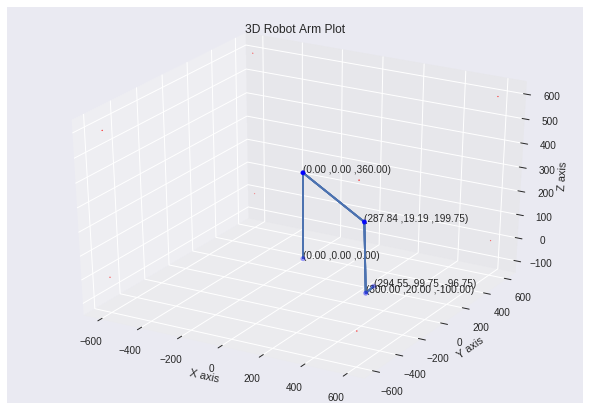

In [117]:
if __name__ == "__main__":
  Arm = arm()
  Arm.RunStep(2,Animation=False)
